<a href="https://colab.research.google.com/github/vigneshK0404/NOva_Fitter_CNF/blob/main/CNF_Modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torchinfo
!pip install nflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53654 sha256=edebaf0388f449497b10be382c24952c2d1e6a2b33bf0349e6d819f3bf3c2e1d
  Stored in directory: /root/.cache/pip/wheels/fd/27/c3/8952205ea17b63dc1eaa24031e63111c6a3661cb22cc1e2a3c
Successfully built nflows


In [3]:
import torch
import torchinfo
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import tqdm
from torch.utils.data import DataLoader
import time

In [4]:
from nflows.flows.base import Flow  # a container for full Flow
from nflows.distributions.normal import StandardNormal  # Gaussian latent space distribution
from nflows.transforms.base import (
    CompositeTransform,
)  # a wrapper to stack simpler transformations to form a more complex one
from nflows.transforms.autoregressive import (
    MaskedAffineAutoregressiveTransform,
)  # the basic transformation, which we will stack several times
from nflows.transforms.autoregressive import (
    MaskedPiecewiseRationalQuadraticAutoregressiveTransform,
)  # the basic transformation, which we will stack several times
from nflows.transforms.permutations import ReversePermutation # a layer that simply reverts the order of outputs

In [5]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
dnumber = 0
device = torch.device(f"cuda:{dnumber}" if torch.cuda.is_available() else "cpu")
print(device)
device_name = torch.cuda.get_device_name(dnumber)
print(device_name)

True
1
cuda:0
NVIDIA A100-SXM4-80GB


In [6]:
def gauss(N,mu,sig,x):
    N_t = N.reshape(-1,1)
    mu_t = mu.reshape(-1,1)
    sig_t = sig.reshape(-1,1)

    term1 = N_t / (sig_t * np.sqrt(2 * np.pi))
    term2 = np.exp(-0.5 * np.square((x - mu_t) / sig_t))
    return np.array(term1 * term2)


def generatePrior(sampleSize):
    N1 = np.random.uniform(10,50,sampleSize)
    N2 = np.random.uniform(10,30,sampleSize)

    mu1 = np.random.uniform(1,3,sampleSize)
    mu2 = np.random.uniform(5,9,sampleSize)

    sig1 = np.random.uniform(1,3,sampleSize)
    sig2 = np.random.uniform(5,9,sampleSize)

    return N1,mu1,sig1,N2,mu2,sig2


def generateTrainingData(uniqueSampleNum, sampleNumber):

  N1,mu1,sig1,N2,mu2,sig2 = generatePrior(uniqueSampleNum)

  raw = np.arange(0.5,10,1) #startbinCenter, endBinEdge, StepSize [0.5,1.5...9.5]
  gaussTotal = gauss(N1,mu1,sig1,raw) + gauss(N2,mu2,sig2,raw)
  thetaData = np.column_stack((N1,mu1,sig1,N2,mu2,sig2))

  fullGaussMatrix = np.repeat(gaussTotal,repeats=sampleNumber,axis=0)
  dataPoisson = np.random.poisson(lam=fullGaussMatrix,size=None)

  fullthetaData = np.repeat(thetaData,repeats=sampleNumber,axis=0)

  return dataPoisson, fullthetaData

dataPoisson, thetaData = generateTrainingData(10000,1000)




In [7]:
print(thetaData[999:1001])
print(dataPoisson[999:1001])

[[38.11326539  1.14188786  1.8054577  19.35588386  6.36003954  5.67251996]
 [27.71478449  1.16198264  2.78503538 29.02185883  7.22710602  6.20521619]]
[[12 10  6  8  2  4  0  2  1  2]
 [ 8  2  3  7  4  3  4  2  0  2]]


In [8]:
class autoEncoder(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim):
    super().__init__()

    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(input_dim,32),
        torch.nn.ReLU(),
        torch.nn.Linear(32,hidden_dim)
    )

    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(hidden_dim,32),
        torch.nn.ReLU(),
        torch.nn.Linear(32,input_dim),
    )

  def encode(self,x):
    return self.encoder(x)

  def decode(self,x):
    return self.decoder(x)

  def forward(self,x):
    eData = self.encode(x)
    dData = self.decode(eData)
    return dData

In [9]:
input_dim = 10
n_features = 6 #doubles as hidden_dim
contextF = 6 #N1,N2,mu1,mu2,sig1,sig2
n_layers = 10

encodeModel = autoEncoder(input_dim,n_features).to(device)
reconOptim = torch.optim.Adam(encodeModel.parameters(), lr = 1e-4)
print(torchinfo.summary(encodeModel))
rloss = torch.nn.MSELoss()

Layer (type:depth-idx)                   Param #
autoEncoder                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       352
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       198
├─Sequential: 1-2                        --
│    └─Linear: 2-4                       224
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       330
Total params: 1,104
Trainable params: 1,104
Non-trainable params: 0


100%|██████████| 5/5 [03:16<00:00, 39.35s/it]

5


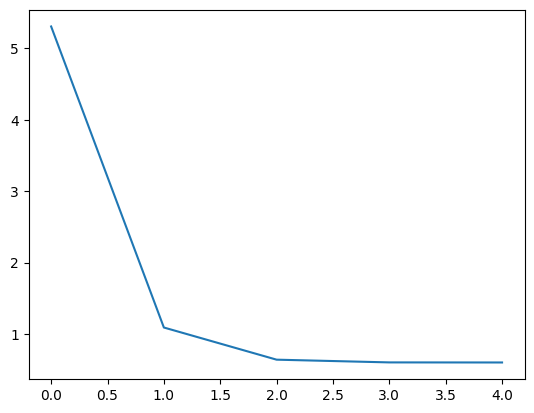

In [10]:
max_iter = 5
r_losses = []
Datasets = DataLoader(dataPoisson, batch_size = 4096, shuffle=True)

for iter in tqdm.tqdm(range(max_iter)):
  iter_losses = []
  for x_batch in Datasets:
      x_batch = x_batch.to(device, non_blocking=True).float()
      reconOptim.zero_grad()
      y_pred = encodeModel(x_batch)
      loss = rloss(y_pred, x_batch)
      iter_losses.append(loss.item())
      loss.backward()
      reconOptim.step()

  r_losses.append(np.mean(np.array(iter_losses)))

print(len(r_losses))
plt.plot(r_losses)

In [11]:
print(r_losses[-1])

0.6002334522527325


[10.997857   16.004025   11.00635     2.0038822   4.988723    0.87076366
  1.0894222   1.0770333   1.0689824   1.0336341 ]
[11. 16. 11.  2.  5.  1.  1.  1.  0.  2.]


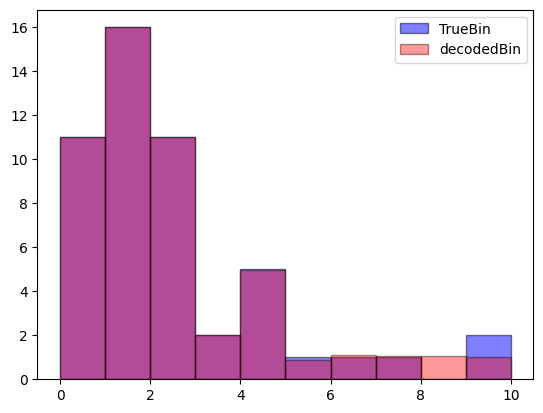

In [12]:
testP,_ = generateTrainingData(1,1)
testP = torch.tensor(testP, dtype = torch.float32)
testP = testP.to(device)
decodePtest = encodeModel(testP).to("cpu").detach().numpy().flatten()
testP_CPU = testP.to("cpu").detach().numpy().flatten()

print(decodePtest)
print(testP_CPU)

bins = np.array(range(11))
plt.hist(bins[:-1], bins,weights=testP_CPU,color='blue',edgecolor='black',alpha=0.5,label="TrueBin")
plt.hist(bins[:-1], bins,weights=decodePtest,color='red',edgecolor='black',alpha=0.4,label="decodedBin")
plt.legend()

In [13]:
class CNF():
  def __init__(self,n_features, context_features,n_layers):

    base_dist = StandardNormal(shape=[n_features])
    transforms = []

    for i in range(n_layers):
      transforms.append(MaskedAffineAutoregressiveTransform(features=n_features, hidden_features=16, context_features=6)) #we are conditioning on 6 column data Ni,MUi and Stdi i{1,2}
      transforms.append(ReversePermutation(features=n_features))

    transform = CompositeTransform(transforms)
    self.flow = Flow(transform,base_dist)


In [16]:
CNFModel = CNF(n_features,context_features= contextF,n_layers=10).flow.to(device)
flowOptim = torch.optim.Adam(CNFModel.parameters(), lr = 1e-3)

print(torchinfo.summary(CNFModel))

Layer (type:depth-idx)                                       Param #
Flow                                                         --
├─CompositeTransform: 1-1                                    --
│    └─ModuleList: 2-1                                       --
│    │    └─MaskedAffineAutoregressiveTransform: 3-1         1,740
│    │    └─ReversePermutation: 3-2                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-3         1,740
│    │    └─ReversePermutation: 3-4                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-5         1,740
│    │    └─ReversePermutation: 3-6                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-7         1,740
│    │    └─ReversePermutation: 3-8                          --
│    │    └─MaskedAffineAutoregressiveTransform: 3-9         1,740
│    │    └─ReversePermutation: 3-10                         --
│    │    └─MaskedAffineAutoregressiveTransform: 3-11        1,740
│    │    └─Rever

In [17]:
batch_size = 1000
num_iter = 5 #reduce number of iterations this converges a lot quicker

max_batch = int(dataPoisson.shape[0] / batch_size)

logLoss = []

for i in tqdm.tqdm(range(num_iter)):
  permut = np.random.permutation(dataPoisson.shape[0])
  dataPoisson_shufle = dataPoisson[permut]
  thetaData_shuffle = thetaData[permut]

  for i_batch in range(max_batch):
    start = i_batch * batch_size
    end = start + batch_size

    pData = torch.tensor(dataPoisson_shufle[start:end], device = device).float()
    tData = torch.tensor(thetaData_shuffle[start:end], device = device).float()

    pData_encoded = encodeModel.encode(pData)

    flowOptim.zero_grad()

    nll = -CNFModel.log_prob(tData, context=pData_encoded)

    cnf_loss = nll.mean()
    logLoss.append(cnf_loss.item())

    if(i_batch % 100 == 0):
      print(f"nll:{cnf_loss}")

    cnf_loss.backward()
    flowOptim.step()





  0%|          | 0/5 [00:00<?, ?it/s]

nll:2287409119100928.0
nll:74.3191146850586
nll:61.3307991027832
nll:55.64017105102539
nll:50.339202880859375
nll:48.48697280883789
nll:39.44327163696289
nll:34.56090545654297
nll:30.07107162475586
nll:31.4468994140625
nll:30.125333786010742
nll:28.304250717163086
nll:25.84479522705078
nll:25.34721565246582
nll:24.62592124938965
nll:23.544172286987305
nll:24.05923080444336
nll:41.093379974365234
nll:36.67669677734375
nll:35.16813659667969
nll:34.802268981933594
nll:34.02788543701172
nll:33.31956100463867
nll:31.900163650512695
nll:30.99475860595703
nll:30.14508819580078
nll:28.971765518188477
nll:27.82375144958496
nll:26.950313568115234
nll:25.864192962646484
nll:26.435068130493164
nll:25.49506187438965
nll:25.04559898376465
nll:25.568265914916992
nll:24.658504486083984
nll:24.890140533447266
nll:24.7271728515625
nll:24.08806037902832
nll:23.752294540405273
nll:23.34349822998047
nll:23.074134826660156
nll:23.08708381652832
nll:22.488201141357422
nll:22.21778678894043
nll:22.65499496459

 20%|██        | 1/5 [04:38<18:33, 278.29s/it]

nll:13.997537612915039
nll:13.890829086303711
nll:13.987367630004883
nll:13.801362037658691
nll:13.760642051696777
nll:13.620499610900879
nll:13.785408973693848
nll:13.579756736755371
nll:13.374387741088867
nll:13.417420387268066
nll:13.45695972442627
nll:13.51621150970459
nll:13.251811027526855
nll:13.20971393585205
nll:13.300642967224121
nll:13.372166633605957
nll:13.122865676879883
nll:13.191930770874023
nll:13.008889198303223
nll:13.026346206665039
nll:13.058748245239258
nll:12.702327728271484
nll:12.916954040527344
nll:13.972914695739746
nll:12.801094055175781
nll:12.733572959899902
nll:12.693807601928711
nll:12.474953651428223
nll:12.692924499511719
nll:12.384469985961914
nll:12.326119422912598
nll:12.451598167419434
nll:12.452692031860352
nll:12.258035659790039
nll:12.253969192504883
nll:12.314642906188965
nll:12.094863891601562
nll:12.200019836425781
nll:12.057191848754883
nll:12.027527809143066
nll:12.105542182922363
nll:12.128863334655762
nll:11.954648971557617
nll:11.8889493

 40%|████      | 2/5 [09:15<13:53, 277.91s/it]

nll:10.699742317199707
nll:10.666332244873047
nll:10.790952682495117
nll:10.751535415649414
nll:10.685548782348633
nll:10.7832612991333
nll:10.608158111572266
nll:10.693571090698242
nll:10.775196075439453
nll:10.65576457977295
nll:10.691488265991211
nll:10.672385215759277
nll:10.696016311645508
nll:10.6793851852417
nll:10.679627418518066
nll:10.660673141479492
nll:10.555150032043457
nll:10.59294605255127
nll:10.50654411315918
nll:10.629424095153809
nll:10.56009578704834
nll:10.642488479614258
nll:10.535628318786621
nll:10.582304954528809
nll:10.68190860748291
nll:10.604109764099121
nll:10.52995777130127
nll:10.565653800964355
nll:10.679000854492188
nll:10.479338645935059
nll:10.588095664978027
nll:10.508003234863281
nll:10.521028518676758
nll:10.588594436645508
nll:10.556289672851562
nll:10.565601348876953
nll:10.632369995117188
nll:10.48657512664795
nll:10.522221565246582
nll:10.527915000915527
nll:10.488601684570312
nll:10.417034149169922
nll:10.440914154052734
nll:10.568426132202148

 60%|██████    | 3/5 [13:53<09:15, 277.62s/it]

nll:10.406866073608398
nll:10.36608600616455
nll:10.366259574890137
nll:10.343216896057129
nll:10.30903148651123
nll:10.319524765014648
nll:10.381826400756836
nll:10.345236778259277
nll:10.417584419250488
nll:10.366862297058105
nll:10.300305366516113
nll:10.344511985778809
nll:10.346109390258789
nll:10.3868989944458
nll:10.36867618560791
nll:10.282203674316406
nll:10.373607635498047
nll:10.277134895324707
nll:10.337692260742188
nll:10.375889778137207
nll:10.298584938049316
nll:10.36172103881836
nll:10.342698097229004
nll:10.273027420043945
nll:10.282118797302246
nll:10.309657096862793
nll:10.352227210998535
nll:10.30774211883545
nll:10.327722549438477
nll:10.290648460388184
nll:10.249326705932617
nll:10.379993438720703
nll:10.275850296020508
nll:10.28647232055664
nll:10.322168350219727
nll:10.359947204589844
nll:10.37324047088623
nll:10.313936233520508
nll:10.376021385192871
nll:10.265935897827148
nll:10.310274124145508
nll:10.30201244354248
nll:10.365615844726562
nll:10.26236534118652

 80%|████████  | 4/5 [18:31<04:38, 278.07s/it]

nll:10.299195289611816
nll:10.198851585388184
nll:10.16562557220459
nll:10.226149559020996
nll:10.249367713928223
nll:10.242135047912598
nll:10.112611770629883
nll:10.248307228088379
nll:10.206995010375977
nll:10.329828262329102
nll:10.154211044311523
nll:10.26072883605957
nll:10.169258117675781
nll:10.129030227661133
nll:10.244195938110352
nll:10.216571807861328
nll:10.2262601852417
nll:10.196499824523926
nll:10.249011993408203
nll:10.170711517333984
nll:10.247635841369629
nll:10.254422187805176
nll:10.099845886230469
nll:10.218534469604492
nll:10.184544563293457
nll:10.086167335510254
nll:10.227721214294434
nll:10.169608116149902
nll:10.181953430175781
nll:10.181713104248047
nll:10.206094741821289
nll:10.186694145202637
nll:10.194594383239746
nll:10.193185806274414
nll:10.062607765197754
nll:10.22470474243164
nll:10.109635353088379
nll:10.241764068603516
nll:10.242901802062988
nll:10.108687400817871
nll:10.243141174316406
nll:10.224701881408691
nll:10.131701469421387
nll:10.101660728

100%|██████████| 5/5 [23:10<00:00, 278.08s/it]


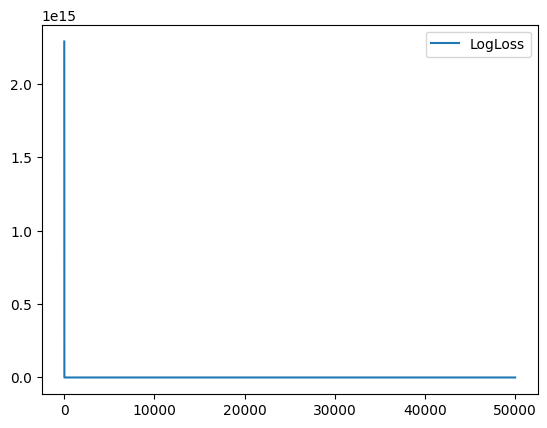

10.123469352722168


In [19]:
plt.plot(logLoss,label="LogLoss")
plt.legend()
plt.show()

print(logLoss[-1])

In [18]:
torch.save({
    "cnf": CNFModel.state_dict(),
    "optimizer": flowOptim.state_dict(),
}, "CNF_params_Optim.pth")

torch.save({
    "ae": encodeModel.state_dict(),\
    "AE_Optim": reconOptim.state_dict(),
}, "AE_params_Optim.pth")
